In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import dotenv
from huggingface_hub import login
import os
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from src.utils import read_config
from src.data_utils import prepare_dataset_gender
from src.utils import read_config
from datasets import load_dataset, concatenate_datasets
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from peft import PeftModel

dotenv.load_dotenv()
login(token=os.getenv('huggingface_token'))


%load_ext autoreload
%autoreload 2

/home/kaysinbd/Programs/my_projects/kaysinb/GenderBias-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm_configs = read_config('../configs/llm_config.yaml')
dataset_config = read_config('../configs/dataset_config.yaml')
print(llm_configs)

{'local_generative_model_name': 'Qwen/Qwen2.5-0.5B-Instruct', 'chatgpt_generative_model_name': 'gpt-4o-2024-11-20', 'gpt_model_to_check_gender': 'gpt-4o-2024-11-20'}


In [3]:
def get_checkpoints(checkpoint_folders):
    checkpoints = []
    for checkpoint_folder in checkpoint_folders:
        folders_list = [os.path.join(checkpoint_folder, check_point) for check_point in os.listdir(checkpoint_folder)]
        folders_list.sort(key=lambda x: int(x.split('-')[-1]))
        checkpoints.extend(folders_list)
    return checkpoints

def get_model_name(checkpoint_folder):
    if 'att_mod' in checkpoint_folder:
        model_type = 'att_mod'
    elif 'mlp_mod' in checkpoint_folder:
        model_type = 'mlp_mod'
    else:
        raise ValueError(f"Unknown model type in path: {checkpoint_folder}")

    checkpoint_num = checkpoint_folder.split('-')[-1]
    model_name = f"{model_type}_{checkpoint_num}"
    
    return model_name

# Proxy metrics
P(gb) - gender bias probability |male - female| and  P(sp) - sum probability (male + female)


In [18]:
# for custom dataset
dataset_gender = prepare_dataset_gender('../configs/dataset_config.yaml', '../data/short_profession_templates.txt')

# # for Professions Dataset
# print('***** Professions Dataset validation *****')
# dataset_gender_validation = prepare_dataset_gender('../configs/dataset_config.yaml', '../data/Professions Dataset.txt', train_share=0.0, validation_share=1.0, print_dataset_info=True)['validation']
# print('\n***** Professions Dataset test *****')
# dataset_gender_test = prepare_dataset_gender('../configs/dataset_config.yaml', '../data/Professions Dataset.txt', train_share=0.0, validation_share=0.0, print_dataset_info=True)['test']

# dataset_gender = {
#     'validation': dataset_gender_validation,
#     'test': dataset_gender_test
# }


In [5]:
dataset_gender['validation'][0]

{'context': 'Write a short story about the soldier\nThe soldier said that',
 'pronoun_list': ['Ġhe', 'Ġshe']}

In [6]:
validation_professions = dataset_config['validation_professions']
test_professions = dataset_config['test_professions']

In [7]:
class PronounProbabilityCalculator:
    def __init__(self, model, tokenizer, device):
        self.device = device
        self.tokenizer = tokenizer
        self.model = model
        self.model.to(self.device)
        self.model.eval()
    
    def get_probabilities(self, context, male_pronoun_token, female_pronoun_token):
        female_pronoun_token_id = self.tokenizer.convert_tokens_to_ids(female_pronoun_token)
        male_pronoun_token_id = self.tokenizer.convert_tokens_to_ids(male_pronoun_token)

        inputs = self.tokenizer(context, return_tensors='pt').to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
    
        last_token_logits = logits[0, -1, :]
        probs = F.softmax(last_token_logits, dim=-1)
        
        female_pronoun_prob = probs[female_pronoun_token_id].item()
        male_pronoun_prob = probs[male_pronoun_token_id].item()
        
        top5_probs, top5_ids = torch.topk(probs, 5)
        top5_tokens = self.tokenizer.convert_ids_to_tokens(top5_ids.tolist())
        top5 = {token: prob.item() for token, prob in zip(top5_tokens, top5_probs)}
        
        return {'female_pronoun_prob': female_pronoun_prob, 'male_pronoun_prob': male_pronoun_prob, 'top5': top5}

In [8]:
def get_probabilities_for_dataset(dataset_to_check, profession_list, pronoun_probability_calculator):
    result_dict = {}
    for profession in profession_list:
        result_dict[profession.lower()] = defaultdict(list)

    for example in dataset_to_check:
        context = example['context']
        male_pronoun_token = example['pronoun_list'][0]
        female_pronoun_token = example['pronoun_list'][1]
        profession = None
        for profession in profession_list:
            profession = profession.lower()
            if f'the {profession}\n' in context:
                break
        if profession is None:
            print(f'Error: profession not found in context: {context}')
            continue

        probabilities = pronoun_probability_calculator.get_probabilities(context, male_pronoun_token, female_pronoun_token)
        result_dict[profession]['male_pronoun_prob'].append(probabilities['male_pronoun_prob'])
        result_dict[profession]['female_pronoun_prob'].append(probabilities['female_pronoun_prob'])
        result_dict[profession]['top5'].append(probabilities['top5'])
        result_dict[profession]['P(gb)'].append(abs(probabilities['male_pronoun_prob'] - probabilities['female_pronoun_prob']))
        result_dict[profession]['P(sp)'].append(probabilities['female_pronoun_prob'] + probabilities['male_pronoun_prob'])

    return result_dict


In [9]:
def check_and_save(result_path, tmp_result_df=None):
    if os.path.exists(result_path):
        df_result = pd.read_csv(result_path)
    else:
        df_result = pd.DataFrame({'model_name': [], 'split': [], 'profession': [], 'P(gb)': [], 'P(sp)': []})
    if tmp_result_df is not None:
        df_result = pd.concat([df_result, tmp_result_df], ignore_index=True)
        df_result.to_csv(result_path, index=False)
    
    return df_result

def count_proxy_metrics(base_model_name, datasets_dict, professions_dict, checkpoint_folders, result_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    model = AutoModelForCausalLM.from_pretrained(base_model_name)
    model.to(device)
    model.eval()

    df_result = check_and_save(result_path)
    for checkpoint_folder in tqdm(checkpoint_folders):
        if checkpoint_folder == 'base_model':
            lora_model = model
            model_name = 'base_model'
        else:
            model_name = get_model_name(checkpoint_folder)
            lora_model = PeftModel.from_pretrained(model, checkpoint_folder)
        pronoun_probability_calculator = PronounProbabilityCalculator(lora_model, tokenizer, device)
        for split in ['validation', 'test']:
            if len(df_result[(df_result['model_name'] == model_name) & (df_result['split'] == split)]) > 0:
                continue
            dataset = datasets_dict[split]
            profession_list = professions_dict[split]
            result_dict = get_probabilities_for_dataset(dataset, profession_list, pronoun_probability_calculator)
            for profession in profession_list:
                gb_mean = np.mean(result_dict[profession]['P(gb)'])
                sp_mean = np.mean(result_dict[profession]['P(sp)'])
                tmp_df = pd.DataFrame({'model_name': [model_name], 'split': [split], 'profession': [profession], 'P(gb)': [gb_mean], 'P(sp)': [sp_mean]})
                df_result = check_and_save(result_path, tmp_df)


In [11]:
checkpoint_folders = [ '../../att_mod_p_pow_1i3_lambda_gender_2i0']
check_points = get_checkpoints(checkpoint_folders)

datasets_dict = {
    'validation': dataset_gender['validation'],
    'test': dataset_gender['test']
}
professions_dict = {
    'validation': [profession.lower() for profession in validation_professions],
    'test': [profession.lower() for profession in test_professions]
}
result_path = '../experimental_results/proxy_metrics_results_professions_dataset.csv'
check_points = ['base_model'] + check_points
count_proxy_metrics(llm_configs['local_generative_model_name'], datasets_dict, professions_dict, check_points, result_path)

100%|██████████| 24/24 [05:05<00:00, 12.72s/it]


In [12]:
def plot_probabilities(result_dict):
    """
    plot two professions - histograms:
    - P(gb) mean - gender bias probability (male - female)
    - P(sp) mean - sum probability (male + female)
    """
    # Calculate means for each profession
    profession_means = {}
    for profession in result_dict:
        gb_mean = np.mean(result_dict[profession]['P(gb)'])
        sp_mean = np.mean(result_dict[profession]['P(sp)'])
        profession_means[profession] = {'P(gb)': gb_mean, 'P(sp)': sp_mean}
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot P(gb) means
    professions = list(profession_means.keys())
    gb_means = [profession_means[p]['P(gb)'] for p in professions]
    ax1.bar(professions, gb_means)
    ax1.set_title('Gender Bias Probability Mean by Profession')
    ax1.set_xlabel('Profession')
    ax1.set_ylabel('P(gb) Mean')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot P(sp) means
    sp_means = [profession_means[p]['P(sp)'] for p in professions]
    ax2.bar(professions, sp_means)
    ax2.set_title('Sum Probability Mean by Profession')
    ax2.set_xlabel('Profession')
    ax2.set_ylabel('P(sp) Mean')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()



In [13]:
def plot_proxy_metrics(df_result):
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']
    df_result = df_result.copy()
    df_result = df_result.groupby(['model_name', 'split'])[['P(gb)', 'P(sp)']].mean().reset_index()
    zero_pgb = None
    zero_psp = None
    if 'base_model' in df_result['model_name'].unique():
        zero_pgb = df_result[df_result['model_name'] == 'base_model']['P(gb)'].values[0]
        zero_psp = df_result[df_result['model_name'] == 'base_model']['P(sp)'].values[0]
        df_result = df_result[df_result['model_name'] != 'base_model']


    df_result['step'] = df_result['model_name'].apply(lambda x: int(x.split('_')[-1]))
    df_result['model_name'] = df_result['model_name'].apply(lambda x: x.rsplit('_',1)[0])
    df_result = df_result.sort_values(by=['step'])

    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, model_name in enumerate(df_result['model_name'].unique()):
        color = colors[i%len(colors)]

        model_validation_mask = (df_result['model_name'] == model_name) & (df_result['split'] == 'validation')
        model_test_mask = (df_result['model_name'] == model_name) & (df_result['split'] == 'test')

        model_pgb_validation = df_result[model_validation_mask]['P(gb)'].values
        model_pgb_test = df_result[model_test_mask]['P(gb)'].values

        model_psp_validation = df_result[model_validation_mask]['P(sp)'].values
        model_psp_test = df_result[model_test_mask]['P(sp)'].values

        model_steps_validation = df_result[model_validation_mask]['step'].values
        model_steps_test = df_result[model_test_mask]['step'].values


        if zero_pgb is not None and zero_psp is not None:
            model_pgb_validation = np.append(zero_pgb, model_pgb_validation)
            model_pgb_test = np.append(zero_pgb, model_pgb_test)
            model_psp_validation = np.append(zero_psp, model_psp_validation)
            model_psp_test = np.append(zero_psp, model_psp_test)
            model_steps_validation = np.append(0, model_steps_validation)
            model_steps_test = np.append(0, model_steps_test)

        ax[0].plot(model_steps_validation, model_pgb_validation, color=color, label=model_name + ' validation'  )
        ax[0].plot(model_steps_test, model_pgb_test, color=color, label=model_name + ' test', linestyle='--')
        ax[1].plot(model_steps_validation, model_psp_validation, color=color, label=model_name + ' validation')
        ax[1].plot(model_steps_test, model_psp_test, color=color, label=model_name + ' test', linestyle='--')

    ax[0].set_title('Gender Bias Probability Mean by Profession')
    ax[0].set_xlabel('Step')
    ax[0].set_ylabel('P(gb) Mean')
    ax[1].set_title('Sum Probability Mean by Profession')
    ax[1].set_xlabel('Step')
    ax[1].set_ylabel('P(sp) Mean')
    ax[0].legend()
    ax[1].legend()
    plt.show()

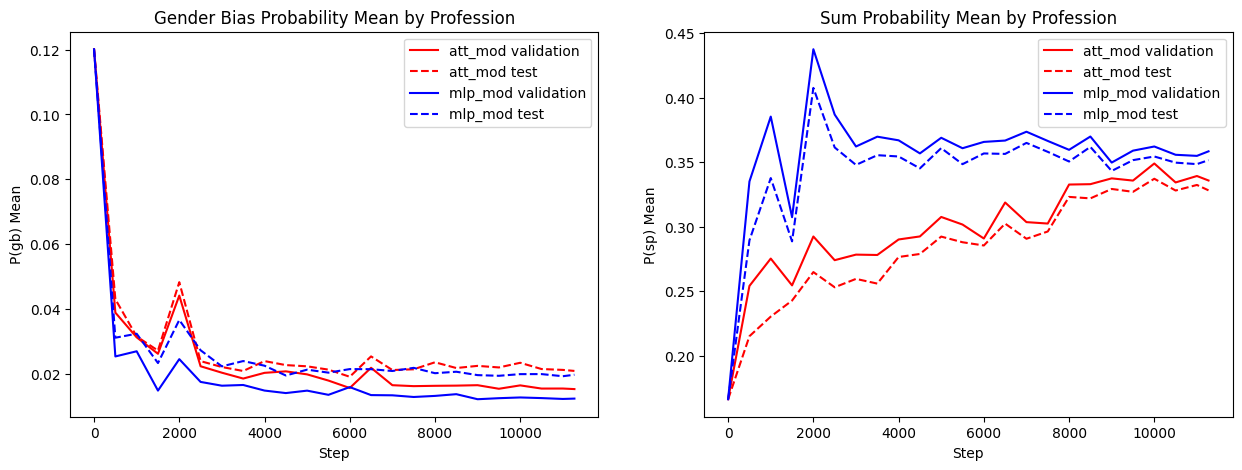

In [45]:
result_path = '../experimental_results/proxy_metrics_results.csv'
df_result = pd.read_csv(result_path)
plot_proxy_metrics(df_result)

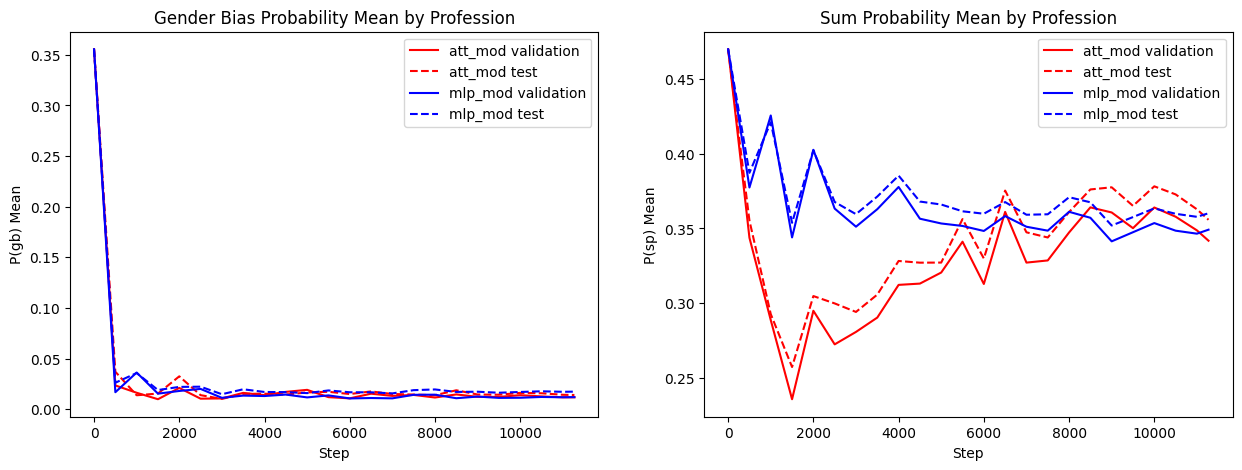

In [14]:
result_path = '../experimental_results/proxy_metrics_results_professions_dataset.csv'
df_result = pd.read_csv(result_path)
plot_proxy_metrics(df_result)

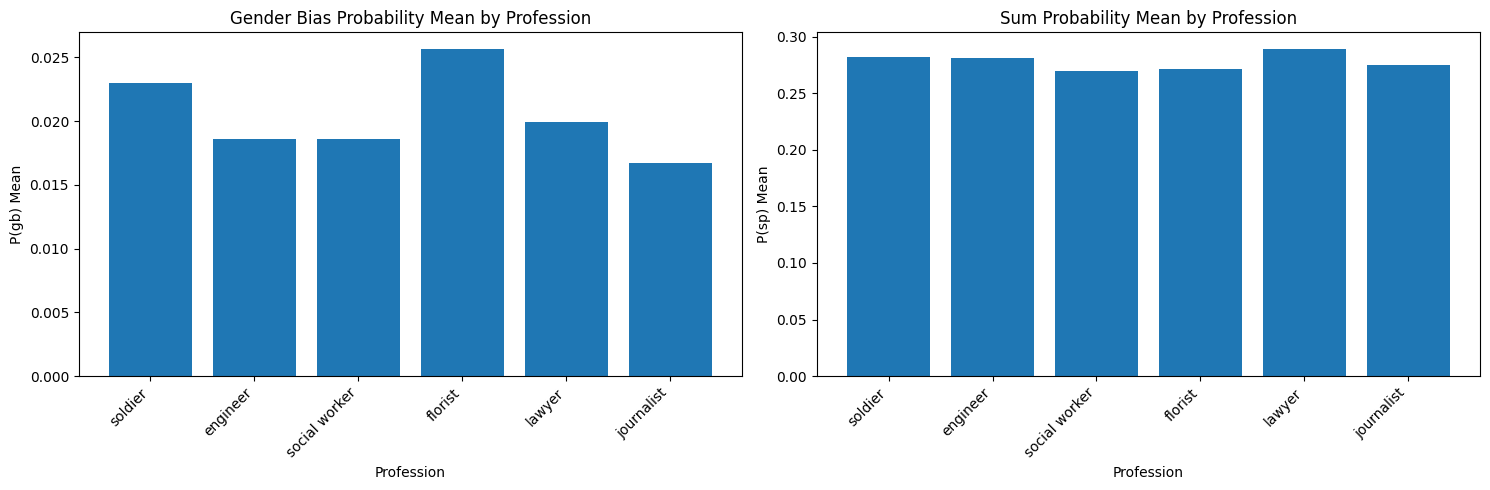

In [90]:
plot_probabilities(result_dict)

# Benchmarks

In [69]:
from src.benchmark_utils import evaluate_copa, evaluate_piqa, evaluate_lambada_next_token_accuracy

In [5]:
copa = load_dataset("super_glue", "copa", trust_remote_code=True)
copa_test = concatenate_datasets([copa['validation'], copa['train']])

piqa = load_dataset("piqa", trust_remote_code=True)
piqa_test = piqa["validation"]
piqa_test = piqa_test.shuffle(seed=42)
piqa_test = piqa_test.select(range(1000))

lambada = load_dataset("lambada", trust_remote_code=True)
lambada_test = lambada["validation"]
lambada_test = lambada_test.shuffle(seed=42)
lambada_test = lambada_test.select(range(1000))


In [6]:
def check_and_save_benchmark(result_path, tmp_result_df=None):
    if os.path.exists(result_path):
        df_result = pd.read_csv(result_path)
    else:
        df_result = pd.DataFrame({'model_name': [], 'accuracy_copa': [], 'accuracy_piqa': [], 'accuracy_lambada': []})
    if tmp_result_df is not None:
        df_result = pd.concat([df_result, tmp_result_df], ignore_index=True)
        df_result.to_csv(result_path, index=False)
    
    return df_result

def evaluate_benchmark(base_model_name, checkpoint_folders, result_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    model = AutoModelForCausalLM.from_pretrained(base_model_name)
    model.to(device)
    model.eval()

    df_result = check_and_save_benchmark(result_path)
    print(df_result)
    for checkpoint_folder in tqdm(checkpoint_folders):
        if checkpoint_folder == 'base_model':
            lora_model = model
            model_name = 'base_model'
        else:
            model_name = get_model_name(checkpoint_folder)
            lora_model = PeftModel.from_pretrained(model, checkpoint_folder)
        if len(df_result[df_result['model_name'] == model_name])  > 0:
            continue
        accuracy_copa = evaluate_copa(lora_model, tokenizer, copa_test) 
        accuracy_piqa = evaluate_piqa(lora_model, tokenizer, piqa_test)
        accuracy_lambada = evaluate_lambada_next_token_accuracy(lora_model, tokenizer, lambada_test)
        tmp_df = pd.DataFrame({'model_name': [model_name], 'accuracy_copa': [accuracy_copa], 'accuracy_piqa': [accuracy_piqa], 'accuracy_lambada': [accuracy_lambada]})
        df_result = check_and_save_benchmark(result_path, tmp_df)

In [7]:
checkpoint_folders = [ '../../att_mod_p_pow_1i3_lambda_gender_2i0']
check_points = get_checkpoints(checkpoint_folders)
check_points = ['base_model'] + check_points
result_path = '../experimental_results/benchmark_results.csv'
evaluate_benchmark(llm_configs['local_generative_model_name'], check_points, result_path)

      model_name  accuracy_copa  accuracy_piqa  accuracy_lambada
0     base_model          0.620          0.700             0.674
1    att_mod_500          0.608          0.708             0.671
2   att_mod_1000          0.608          0.708             0.669
3   att_mod_1500          0.604          0.703             0.673
4   att_mod_2000          0.616          0.708             0.669
5   att_mod_2500          0.618          0.709             0.668
6   att_mod_3000          0.624          0.710             0.669
7   att_mod_3500          0.608          0.710             0.675
8   att_mod_4000          0.618          0.709             0.675
9   att_mod_4500          0.618          0.704             0.673
10  att_mod_5000          0.610          0.706             0.676
11  att_mod_5500          0.616          0.704             0.676
12  att_mod_6000          0.612          0.703             0.677
13  att_mod_6500          0.602          0.701             0.675
14  att_mod_7000         

100%|██████████| 24/24 [23:19<00:00, 58.31s/it] 


In [8]:
checkpoint_folders = [ '../../mlp_mod_p_pow_1i3_lambda_gender_2i0']
check_points = get_checkpoints(checkpoint_folders)
check_points = check_points
result_path = '../experimental_results/benchmark_results.csv'
evaluate_benchmark(llm_configs['local_generative_model_name'], check_points, result_path)

       model_name  accuracy_copa  accuracy_piqa  accuracy_lambada
0      base_model          0.620          0.700             0.674
1     att_mod_500          0.608          0.708             0.671
2    att_mod_1000          0.608          0.708             0.669
3    att_mod_1500          0.604          0.703             0.673
4    att_mod_2000          0.616          0.708             0.669
5    att_mod_2500          0.618          0.709             0.668
6    att_mod_3000          0.624          0.710             0.669
7    att_mod_3500          0.608          0.710             0.675
8    att_mod_4000          0.618          0.709             0.675
9    att_mod_4500          0.618          0.704             0.673
10   att_mod_5000          0.610          0.706             0.676
11   att_mod_5500          0.616          0.704             0.676
12   att_mod_6000          0.612          0.703             0.677
13   att_mod_6500          0.602          0.701             0.675
14   att_m

100%|██████████| 23/23 [2:36:48<00:00, 409.08s/it]  


In [67]:
def plot_benchmark(df_result):
    styles = ['-', '--', '-.']
    df_result = df_result.copy()
    zero_copa = None
    zero_piqa = None
    zero_lambada = None
    if 'base_model' in df_result['model_name'].unique():
        zero_copa = df_result[df_result['model_name'] == 'base_model']['accuracy_copa'].values[0]
        zero_piqa = df_result[df_result['model_name'] == 'base_model']['accuracy_piqa'].values[0]
        zero_lambada = df_result[df_result['model_name'] == 'base_model']['accuracy_lambada'].values[0]
        df_result = df_result[df_result['model_name'] != 'base_model']


    df_result['step'] = df_result['model_name'].apply(lambda x: int(x.split('_')[-1]))
    df_result['model_name'] = df_result['model_name'].apply(lambda x: x.rsplit('_',1)[0])
    df_result = df_result.sort_values(by=['step'])

    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for i, model_name in enumerate(df_result['model_name'].unique()):
        style = styles[i%len(styles)]
        model_mask = (df_result['model_name'] == model_name)

        model_copa = df_result[model_mask]['accuracy_copa'].values
        model_piqa = df_result[model_mask]['accuracy_piqa'].values
        model_lambada = df_result[model_mask]['accuracy_lambada'].values
        model_steps = df_result[model_mask]['step'].values


        if zero_copa is not None and zero_piqa is not None and zero_lambada is not None:
            model_copa = np.append(zero_copa, model_copa)
            model_piqa = np.append(zero_piqa, model_piqa)
            model_lambada = np.append(zero_lambada, model_lambada)
            model_steps = np.append(0, model_steps)

        ax.plot(model_steps, model_copa, label=model_name + ' COPA', color='red', linestyle=style)
        ax.plot(model_steps, model_piqa, label=model_name + ' PIQA', color='blue', linestyle=style)
        ax.plot(model_steps, model_lambada, label=model_name + ' LAMBADA', color='green', linestyle=style)

    ax.set_title('Benchmark Test Accuracy')
    ax.set_xlabel('Step')
    ax.set_ylabel('Accuracy')
    ax.legend()
    plt.show()

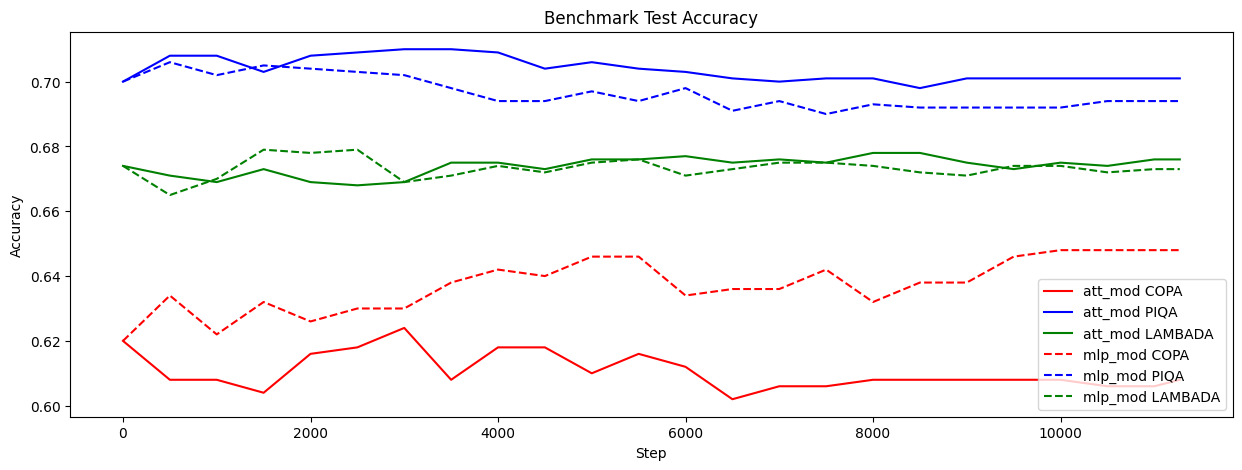

In [68]:
result_path = '../experimental_results/benchmark_results.csv'
df_result = pd.read_csv(result_path)
plot_benchmark(df_result)